# MP1: K-Nearest Neighbors

## Part 1: KNNs from Scratch [75 marks]

Again, you are <span style="color: red;">not allowed</span> to use scikit-learn or any other machine learning toolkit for this part. You have to implement your own k-NN classifier from scratch. 

You can use `numpy`, `pandas`, `seaborn`, `matplotlib`, `PIL`, and the standard Python libraries for this part. Contact the TAs if you want to use any other libraries.

### Importing Libraries

In [1198]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import PIL

# added libraries
from scipy.stats import mode
from statistics import mode

### Loading the dataset

<center>
    <img src="./assets/mnist.png">
</center>

The MNIST dataset consists of 70,000 labeled images of handwritten digits, each of size 28 pixels by 28 pixels.

The dataset given to you is in a CSV file, `mnist.csv`. The CSV file has ~70,000 rows and 785 columns. You can download it using [this link](https://drive.google.com/file/d/16STvH3jEk-JF1BGAguhnA9y0sT_c_MC-/view?usp=sharing).

- Each row represents one image of a handwritten digit. Note that the header row contains the column names.

- The first column gives the label (a number from 0 to 9). The next 784 columns give the value of each pixel. There are 784 pixels in each image corresponding to an image size of 28 by 28.

For faster prototyping, you can sample 20% of the entire dataset.

You can use the `pandas` library to load the CSV file but the final dataset should be stored in a `numpy` array of shape (14000, 785).

In [1199]:
## (3 marks)

# TODO: Load the dataset
data = pd.read_csv('mnist_full.csv')

# TODO: Print the shapes
numpy_data = data.to_numpy() # converting to numpy array
numpy_data = numpy_data[:, 1:]
print(numpy_data.dtype)

# TODO: Display the first 5 rows of the dataset
print("First 5 rows of the original data set: ")
print(numpy_data[0:5,])
print(" ")
print("shape of the data now stored in a numpy array: ", numpy_data.shape) # printing the shape of the data

int64
First 5 rows of the original data set: 
[[5 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [4 0 0 ... 0 0 0]
 [1 0 0 ... 0 0 0]
 [9 0 0 ... 0 0 0]]
 
shape of the data now stored in a numpy array:  (70000, 785)


In [1200]:
# (2 marks)
# TODO: Sample 20% of the dataset (Make sure this is a random sample!)
# Please note that this is not the train-test split. This is just a sample of the dataset. We are doing this to reduce the computation time.

sampled_data = int(0.2*numpy_data.shape[0])
index = np.random.choice(numpy_data.shape[0], sampled_data, replace = False)
sampled_data = numpy_data[index]
print("Shape of the Sampled Data:", sampled_data.shape) # printing shape of the sampled data

Shape of the Sampled Data: (14000, 785)


### Displaying Images

Now that you've loaded the dataset, let's display some images.

You can reshape these 784 values for each image, into a `28x28` array, then use either `matplotlib` or `PIL` to display the image.

In [1201]:
# TODO: Implement a display_image function (3 marks) 

def display_image(arr):
    '''
    Takes a 1D numpy array, reshapes to a 28x28 array and displays the image
    '''
    image = arr.reshape(28, 28)
    %matplotlib inline
    plt.axis('off')
    plt.imshow(image)
    plt.show()

Image  11256


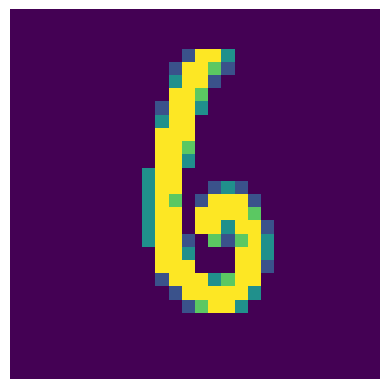

Image  1897


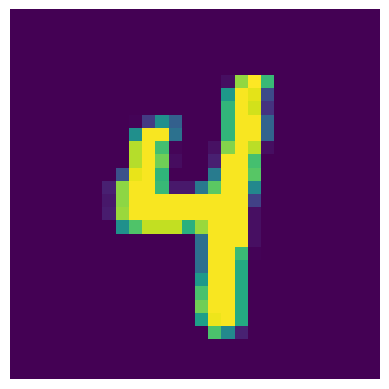

Image  12625


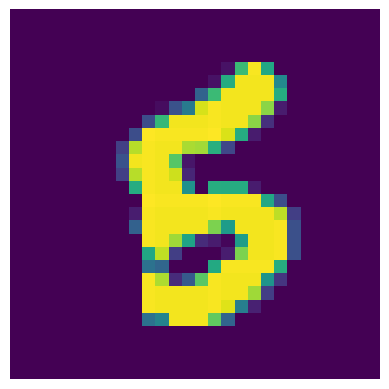

Image  7594


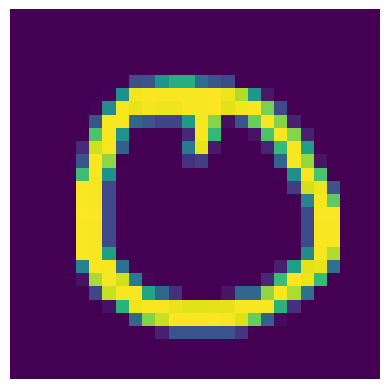

Image  6156


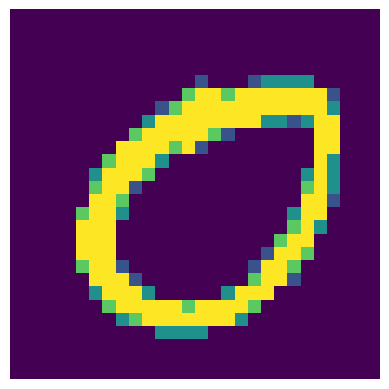

In [1202]:
#TODO: Randomly pick and display 5 images from the dataset

rows = np.random.choice(len(sampled_data), size = 5, replace = False)

for i in rows:
    image_data = sampled_data[i, :]
    image_data = image_data[1 :]
    image_data = image_data
    print('Image ', i)
    display_image(image_data)

### Train-Test split

With the data loaded, you should set up a proper Cross Validation scheme for your modeling experiments, before you actually start building your model.

Divide the dataset into training and test sets (around an 85-15 split). More precisely, take the first 11900 images for the training set and the last 2100 for the test set.

Both the resulting splits/sets should be stored in `numpy` arrays of shape `(num_split_images, 785)`. Depending on your approach, you can also separate the labels into a different array (or two arrays)

In [1203]:
## (3 marks)
# TODO: Create a train-test split (2 marks) 

train_data_size = 11900
test_data_size = 2100
data_train = sampled_data[:train_data_size , :]
data_test = sampled_data[-test_data_size: , :]

# TODO:Print the shapes of both arrays (1 mark) 

print("Shape of data_train:", data_train.shape)
print("Shape of data_test:", data_test.shape)


Shape of data_train: (11900, 785)
Shape of data_test: (2100, 785)


In [1204]:
## (3 marks)
# TODO: Split the train and test into inputs and labels (2 marks)

features_train = data_train[:, 1:] # features for training
labels_train = data_train[:, 0] # labels for training
features_test = data_test[:, 1:] # features for testing
labels_test = data_test[:, 0] # labels for testing

# TODO: Print the shapes of the 4 arrays (1 mark)

print("Shape of features_train:", features_train.shape)
print("Shape of labels_train:", labels_train.shape)
print("Shape of features_test:", features_test.shape)
print("Shape of labels_test:", labels_test.shape)

Shape of features_train: (11900, 784)
Shape of labels_train: (11900,)
Shape of features_test: (2100, 784)
Shape of labels_test: (2100,)


### Implementing k-NN Classifier

#### Instructions

Now you can create your own k-NN classifier. You can use the following steps as a guide:

1. For a test data point, find its distance from all training instances.

2. Sort the calculated distances in ascending order based on distance values.

3. Choose k training samples with minimum distances from the test data point.

4. Return the *most frequent* class of these samples. 

**Note:** Your function should work with *Euclidean* distance as well as *Manhattan* distance. Pass the distance metric as a parameter in the k-NN classifier function. Your function should also let one specify the value of `k`.

For values of `k` where a tie occurs, you need to break the tie by backing off to the `k-1` value. In case there is still a tie, you will continue decreasing `k` until there is a clear winner.

#### Distance functions

First, implement separate functions for the Euclidean and Manhattan distances. Formulas for both are given below.

$$
d_{\text{Euclidean}}(\vec{p},\vec{q}) = \sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + (p_3 - q_3)^2 + ... + (p_n - q_n)^2}
$$

$$
d_{\text{Manhattan}}(\vec{p},\vec{q}) = |(p_1 - q_1)| + |(p_2 - q_2)| + |(p_3 - q_3)| + ... + |(p_n - q_n)|
$$

In [1205]:
def euclidean_distance(vector1,vector2):
    
    # TODO:Implement the euclidean distance function (2 marks)
    euc_distance = np.sqrt(np.sum(np.square(vector1 - vector2), axis = 1)) # applying the given formula
    return euc_distance

def manhattan_distance(vector1,vector2):

    # TODO:Implement Euclidean and Manhattan distance functions (2 marks)
    manh_distance = np.sum(np.abs((vector1 - vector2)),  axis = 1) # applying the given formula 
    return manh_distance


#### k-NN Classifier methods

Complete the following method functions:

1. `fit`

2. `get_neighbours`


3. `predict`

You can make as many helper functions as you need.


In [1206]:
class kNearestNeighbours:
  def __init__(self, num_neibrs): 

    ### DO NOT EDIT !! ###
    """
    n_neighbours: value of k
    X: array of training data points
    y: array of gold labels for training points
    """

    self.n_neighbors = num_neibrs
    self.X = None
    self.y = None
    
    #######################

  
  def fit(self,X_train,y_train):
    '''
    Fit the training data to the model
    '''
    # TODO: Set both attributes (1 mark)
    self.X = X_train # the training data itself ('data_train' basically)
    self.y = y_train # known labels of the training data (known labels of 'data_train')

  def get_neighbors(self, x , distanceFunction):
    """
    Return the k nearest neighbours of the input data point x.
    Hint: you can even just return the indices of the data points

    """
    # TODO: Complete the get_neighbors function (4 marks)
    
    distance_from_x = distanceFunction(x, self.X) # finds the distance between x and other points in training data
    nearest_neighbour_indices = np.argsort(distance_from_x)[:self.n_neighbors] # sorts and then finds and returns the k nearest neighbors required
    return nearest_neighbour_indices
  
  def predict(self, X_test, distanceFunction):
    """
    Returns an array of predicted labels for all points in the X_test array

    Parameters
    ----------
    X_test : array
        The test data

    distanceFunction : function
        The distance function to be used
    """
    labels_predicted = []

    for i in range(X_test.shape[0]):
        neighbor_index = self.get_neighbors(X_test[i,:], distanceFunction)
        label_at__neighbor_index = self.y[neighbor_index].astype(int)
        most_common_label = np.bincount(label_at__neighbor_index).argmax()
        labels_predicted.append(most_common_label)
        
    return np.array(labels_predicted)

Optional Challenge: 

Using for loops can be really slow so in order to improve performance we can leverage the power of vectorization. Try vectorizing the process of finding the distance from a query point to each point in the dataset.

#### Evaluation

Now that you've created a model and "trained" it, you can move on to the Evaluation phase.

- Implement an `evaluate` function that computes the Confusion Matrix, Accuracy, and Macro-Average F1 score of your classifier. 
- The function should take as input the predicted labels and the true labels. This will be built in steps: its easier to create a Confusion Matrix, then calculate things like the Precision, Recall and F1 from it.

- We will also implement a function that displays our confusion matrix as a heatmap annotated with the data values. 
- The axes should be properly labelled and the colormap used needs to be shown next to the heatmap. 
- You can have a look at some examples of heatmaps [here](https://seaborn.pydata.org/generated/seaborn.heatmap.html). (You don't have to use the seaborn libray, but it has some pretty colour palettes to choose from.)

We recommend that you do not use hard coding in this function. 

In [1207]:
def calculate_accuracy(predicted_labels, true_labels):
    '''
    Returns the accuracy of the predictions against the true labels
    
    Parameters
    ----------
    predicted_labels : array

    true_labels : array
    """
    '''
    
    # TODO: Implement a function to calculate accuracy (2 marks) 
       
    correct_predictions = np.sum(predicted_labels == true_labels)
    total_predictions = len(true_labels) # I chose true_labels here because there can be instances where the model doesnt predict anything
    return (correct_predictions/total_predictions).astype(float)


In [1208]:
def make_confusion_matrix(predicted_labels, true_labels):
    '''
    Computes the confusion matrix as a 2D array
    '''
    
    # TODO: Implement a function to compute the confusion matrix (2 marks)

    num_classes = len(np.unique(true_labels))
    
    confusion_matrix = np.zeros((num_classes , num_classes))

    num_labels = len(predicted_labels)

    for i in range(num_labels):
        predicted = predicted_labels[i].astype(int)
        gold = true_labels[i]
        confusion_matrix[predicted.astype(int)][gold] = confusion_matrix[predicted.astype(int)][gold] + 1
    return confusion_matrix

In [1209]:
def make_heat_map(data, title):
    '''
    Creates a heatmap from the 2D matrix input
    '''
    # TODO: Implement a funtion to display a heatmap (2 marks)
    
    plt.figure(figsize=(9, 6))
    sns.heatmap(data, annot = True, cmap = sns.cubehelix_palette(as_cmap = True), linewidths = 1, fmt='.1f')
    plt.title(title)
    plt.xlabel('True Labels')
    plt.ylabel('Predicted Labels')
    plt.show()

In [1210]:
def calculate_precision(confusion_matrix,class_label):
    '''
    Calculates the precision from a provided confusion matrix
    '''
    # TODO: Implement a function to compute the precision (2 marks)

    true_positives = confusion_matrix[class_label][class_label]
    false_positives = sum(confusion_matrix[class_label][i] for i in range(len(confusion_matrix)) if i != class_label) # simple logic to find fp for a particular class label
    precision = (true_positives/(true_positives + false_positives)) # implementing the formula p = tp/(tp + fp)
    
    return precision

In [1211]:
def calculate_recall(confusion_matrix,class_label):
    '''
    Calculates the recall from a provided confusion matrix
    '''
    # TODO: Implement a function to compute the recall (2 marks)
    
    # recall is defined as tp/(tp + fn)
    true_positives = confusion_matrix[class_label][class_label]
    false_negatives = sum(confusion_matrix[i][class_label] for i in range(len(confusion_matrix)) if i != class_label) # logic for fn

    recall = (true_positives/(true_positives + false_negatives)) # implementing the formula recall, r = tp/(tp + fn)

    return recall

In [1212]:

def calculate_f1_score(precision, recall):
    '''
    Calculates the F1 score from a provided precision and recall
    ''' 
    # TODO: Implement a function to compute the F1 score (2 marks)
    
    f1_score = 2 * ((precision * recall)/(precision + recall)) # implementing the formula f1_score = 2pr/(p+r)
    
    return f1_score

In [1213]:
def macro_average_f1(confusion_matrix):
    '''
    Calculates the macro-average F1 score from a provided confusion matrix, over all classes
    '''
    # TODO: Implement a function to compute the Macro-average F1 (2 marks)
    
    f1_scores = []
    for i in range(len(confusion_matrix)):
        tp = confusion_matrix[i][i]

        row_elements = confusion_matrix[i, :] # iterating over all column elements in i'th row
        fp = sum(row_elements) - tp # subtract tp from total to get fp

        column_elements = confusion_matrix[:, i] # iterating over all row elements in i'th col
        fn = sum(column_elements) - tp # subtract tp from total to get fn

        precision = tp/(tp + fp)
        recall = tp/(tp + fn)  
        f1_scores.append(calculate_f1_score(precision, recall)) # using the function I made earlier 
    
    macro_averaged_f1_score = sum(f1_scores)/len(f1_scores)
    
    return macro_averaged_f1_score

In [1214]:
def evaluation(predicted_labels,true_labels):
    '''
    Computes the Confusion Matrix, Accuracy and Macro-average F1 score from the predictions and true labels
    '''
    ## Now put it all together using the functions you've already written above.
    
    # TODO: Complete the evaluation function (2 marks)
    confusion_matrix = make_confusion_matrix(predicted_labels, true_labels)
    accuracy = calculate_accuracy(predicted_labels, true_labels)
    macroF1= macro_average_f1(confusion_matrix)

    return confusion_matrix, accuracy, macroF1

#### `k`-fold Cross Validation

<center>
    <img src="./assets/kfoldcv.png">
</center>

Now with the basics done, you can move on to the next step: `k`-fold Cross Validation. This is a more robust way of evaluating your model since it uses all the data for training and testing (effectively giving you `k` chances to verify the generalizability of your model).

Now, implement a function that performs `k`-fold cross-validation on the training data for a specified value of `k`. 

In Cross Validation, you divide the dataset into `k` parts. `k-1` parts will be used for training and `1` part will be used for validation. You will repeat this process `k` times, each time using a different part for validation. You will then average the results of each fold to get the final result. Take a look at the image above for a better understanding.

The function should return **predictions** for the **entire training data** (size of list/array should be equal to the size of the dataset). This is the result of appending the predicted labels for each validation-train split into a single list/array. Make sure the order of the predicted labels matches the order of the training dataset, so that they may directly be passed to your `evaluate` function together with the actual labels.

In [1215]:
def k_fold_split(k, cv_no, data):
    '''
    Returns the training and validation sets for a given value of k

    Parameters
    ----------
    k : int
        The value of k
    cv_no : int
        The current fold number
    data : array
        The dataset
    '''

    # TODO: Implement a function that creates the train and test splits based off the value of k (5 marks)
    
    width_of_fold = int(len(data) / k) # to ensure that we get an integer for the width of each fold
    starting_index_v = (cv_no - 1) * width_of_fold # starting index for the validation set chosen
    ending_index_v = starting_index_v + width_of_fold if cv_no < k else len(data) # ending index handling the case when we get last fold as our validation set
    validation_set = data[starting_index_v:ending_index_v] # defining the validation set in the data
    training_set = 0

    if cv_no == 1:
        training_set = data[ending_index_v : ]
    elif cv_no == k:
        training_set = data[ : starting_index_v]
    else:
        training_set = np.concatenate((data[0 : starting_index_v], data[ending_index_v : ]))

    return training_set, validation_set

In [1216]:
def k_fold_cross_validation(num_folds, k, dataset, distanceFunction):
    """
    Returns the predictions for all the data points in the dataset using k-fold cross validation

    num_folds: int
      Number of folds
    k: int
      Number of neighbours to consider (hyperparameter)
    dataset: array
      The dataset to be used (note that this should be the training set which has 11900 samples)
    """
    
    # TODO: Implement function to perform k-fold cross-validation, using the above function (10 marks)
    
    pred_lables = np.array([])
    knn = kNearestNeighbours(k)
    for i in range(num_folds):
      train_d,validation_d = k_fold_split(num_folds, i+1, dataset)
      knn.fit(train_d[:, 1:], train_d[:, 0])
      pred_lables = np.concatenate((pred_lables, knn.predict(validation_d[:, 1:], distanceFunction)))
    return pred_lables  

Now run your cross-validation function on the training data using `5-fold cross validation` for the values of `k = [1, 2, 3, 4, 5]`. 

Do this for both the Euclidean distance and the  Manhattan distance for each value of `k`.

Also run your evaluation function for each value of `k` (for both distance metrics) and print out the classification accuracy and F1 score.

(5 marks)

K Fold Cross Validation for [k = 1] - [Manhattan Distance] - [5 folds]


Accuracy [Manhattan]: 0.939327731092437
Macro Average F1 [Manhattan] 0.9386291482147058
Confusion Matrix [Manhattan]
[[1.179e+03 0.000e+00 1.000e+01 4.000e+00 2.000e+00 6.000e+00 1.000e+01
  1.000e+00 8.000e+00 4.000e+00]
 [1.000e+00 1.353e+03 2.200e+01 8.000e+00 1.500e+01 8.000e+00 4.000e+00
  2.100e+01 3.100e+01 7.000e+00]
 [1.000e+00 2.000e+00 1.095e+03 9.000e+00 1.000e+00 0.000e+00 1.000e+00
  7.000e+00 1.400e+01 0.000e+00]
 [0.000e+00 2.000e+00 1.400e+01 1.095e+03 0.000e+00 3.600e+01 0.000e+00
  0.000e+00 3.600e+01 4.000e+00]
 [1.000e+00 1.000e+00 4.000e+00 0.000e+00 1.070e+03 5.000e+00 1.000e+00
  9.000e+00 5.000e+00 3.300e+01]
 [6.000e+00 0.000e+00 2.000e+00 2.800e+01 0.000e+00 9.920e+02 7.000e+00
  1.000e+00 3.200e+01 6.000e+00]
 [4.000e+00 1.000e+00 3.000e+00 2.000e+00 7.000e+00 1.500e+01 1.147e+03
  0.000e+00 9.000e+00 1.000e+00]
 [2.000e+00 4.000e+00 2.700e+01 1.600e+01 5.000e+00 1.000e+00 1.000e+00
  1.161e+03 7.000e+00 3.600e+01]
 [0.000e+00 0.000e+00 7.000e+00 1.300e+01 0

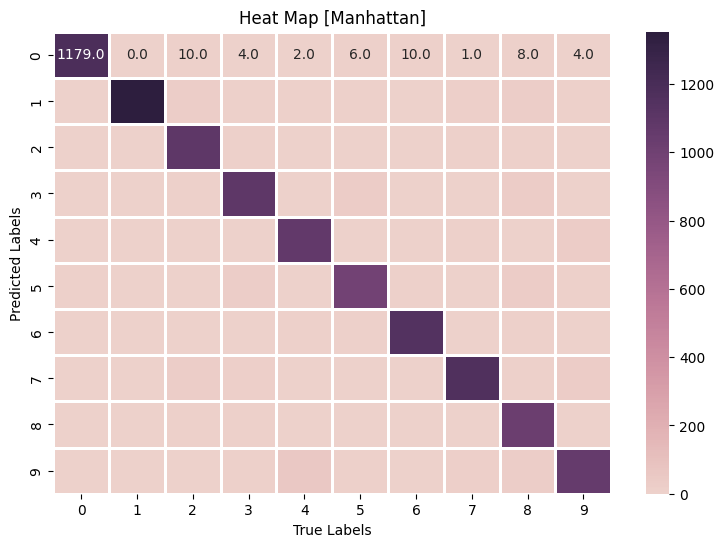

K Fold Cross Validation for [k = 1] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9475630252100841
Macro Average F1 [Euclidean] 0.9469726155540599
Confusion Matrix [Euclidean]
[[1.180e+03 0.000e+00 1.100e+01 3.000e+00 1.000e+00 5.000e+00 1.000e+01
  2.000e+00 4.000e+00 4.000e+00]
 [1.000e+00 1.351e+03 1.400e+01 5.000e+00 1.200e+01 6.000e+00 3.000e+00
  2.000e+01 1.800e+01 4.000e+00]
 [1.000e+00 3.000e+00 1.106e+03 6.000e+00 1.000e+00 0.000e+00 2.000e+00
  8.000e+00 1.400e+01 0.000e+00]
 [1.000e+00 3.000e+00 1.300e+01 1.101e+03 0.000e+00 3.100e+01 0.000e+00
  0.000e+00 2.800e+01 5.000e+00]
 [0.000e+00 2.000e+00 4.000e+00 0.000e+00 1.077e+03 3.000e+00 2.000e+00
  6.000e+00 3.000e+00 2.900e+01]
 [5.000e+00 0.000e+00 1.000e+00 2.200e+01 0.000e+00 1.004e+03 6.000e+00
  1.000e+00 2.400e+01 7.000e+00]
 [2.000e+00 1.000e+00 2.000e+00 1.000e+00 7.000e+00 1.400e+01 1.148e+03
  0.000e+00 7.000e+00 1.000e+00]
 [2.000e+00 3.000e+00 2.400e+01 1.300e+01 3.000e+00 1.000e+00 0.000e+00
  1.165e+03 4

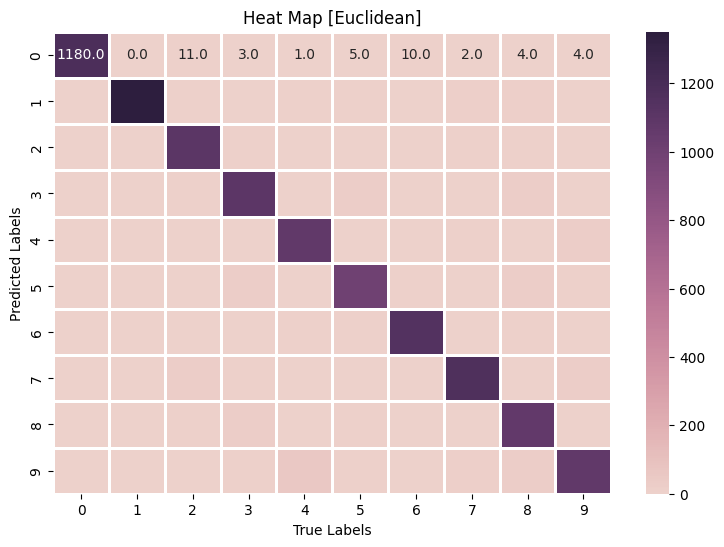

In [1217]:
# TODO: Perform cross-validation and then run your evaluation function for k=1, printing the accuracy and macro-average F1 score.

k = 1
num_of_folds = 5

print('K Fold Cross Validation for [k = 1] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_1, accuracy_1, macro_avg_f1_1 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_1)
print('Macro Average F1 [Manhattan]', macro_avg_f1_1)
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_1)
make_heat_map(confusion_matrix_1,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 1] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_2, accuracy_2, macro_avg_f1_2 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_2)
print('Macro Average F1 [Euclidean]', macro_avg_f1_2)
print('Confusion Matrix [Euclidean]')
print(confusion_matrix_2)
make_heat_map(confusion_matrix_2,'Heat Map [Euclidean]')

K Fold Cross Validation for [k = 2] - [Manhattan Distance] - [5 folds]
Accuracy [Manhattan]: 0.9268067226890756
Macro Average F1 [Manhattan] 0.9257837818541272
Confusion Matrix [Manhattan]
[[1.189e+03 0.000e+00 1.800e+01 7.000e+00 3.000e+00 1.100e+01 2.000e+01
  2.000e+00 1.200e+01 8.000e+00]
 [1.000e+00 1.355e+03 3.900e+01 1.400e+01 2.400e+01 1.200e+01 9.000e+00
  2.900e+01 4.600e+01 7.000e+00]
 [1.000e+00 2.000e+00 1.092e+03 1.600e+01 2.000e+00 1.000e+00 1.000e+00
  9.000e+00 2.600e+01 1.000e+00]
 [0.000e+00 2.000e+00 1.000e+01 1.114e+03 1.000e+00 6.300e+01 0.000e+00
  1.000e+00 6.500e+01 9.000e+00]
 [1.000e+00 1.000e+00 5.000e+00 0.000e+00 1.098e+03 7.000e+00 2.000e+00
  1.700e+01 8.000e+00 7.000e+01]
 [1.000e+00 0.000e+00 1.000e+00 1.100e+01 0.000e+00 9.690e+02 7.000e+00
  1.000e+00 5.600e+01 7.000e+00]
 [0.000e+00 0.000e+00 2.000e+00 0.000e+00 4.000e+00 9.000e+00 1.134e+03
  0.000e+00 1.000e+01 0.000e+00]
 [2.000e+00 3.000e+00 1.500e+01 1.000e+01 5.000e+00 3.000e+00 0.000e+00
  1.

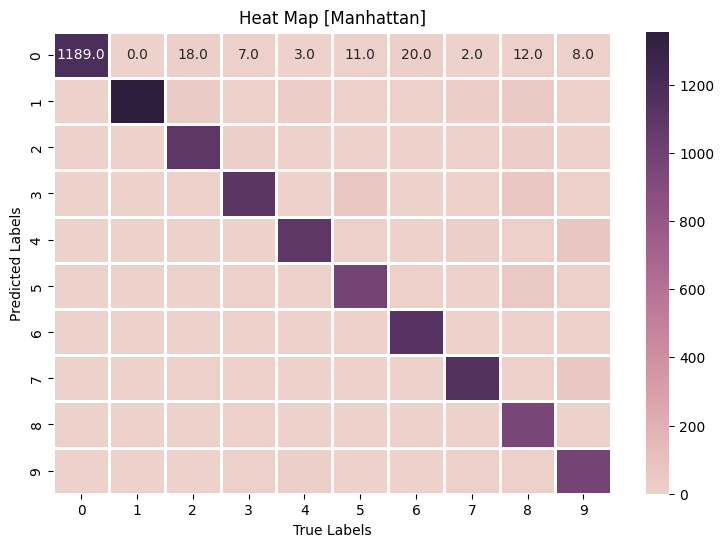

K Fold Cross Validation for [k = 2] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9401680672268907
Macro Average F1 [Euclidean] 0.9394093375677433
Confusion Matrix [Euclidean]
[[1.189e+03 0.000e+00 1.700e+01 3.000e+00 3.000e+00 1.100e+01 2.100e+01
  3.000e+00 7.000e+00 8.000e+00]
 [1.000e+00 1.357e+03 2.200e+01 1.000e+01 1.900e+01 9.000e+00 5.000e+00
  2.800e+01 3.100e+01 5.000e+00]
 [1.000e+00 3.000e+00 1.117e+03 1.700e+01 3.000e+00 1.000e+00 1.000e+00
  8.000e+00 2.400e+01 1.000e+00]
 [1.000e+00 2.000e+00 6.000e+00 1.123e+03 0.000e+00 5.200e+01 0.000e+00
  1.000e+00 5.300e+01 9.000e+00]
 [1.000e+00 0.000e+00 5.000e+00 0.000e+00 1.105e+03 7.000e+00 2.000e+00
  1.600e+01 6.000e+00 5.300e+01]
 [0.000e+00 0.000e+00 0.000e+00 9.000e+00 0.000e+00 9.840e+02 4.000e+00
  2.000e+00 4.100e+01 5.000e+00]
 [0.000e+00 0.000e+00 0.000e+00 0.000e+00 3.000e+00 9.000e+00 1.138e+03
  0.000e+00 1.200e+01 1.000e+00]
 [2.000e+00 1.000e+00 1.300e+01 1.000e+01 3.000e+00 3.000e+00 0.000e+00
  1.153e+03 8

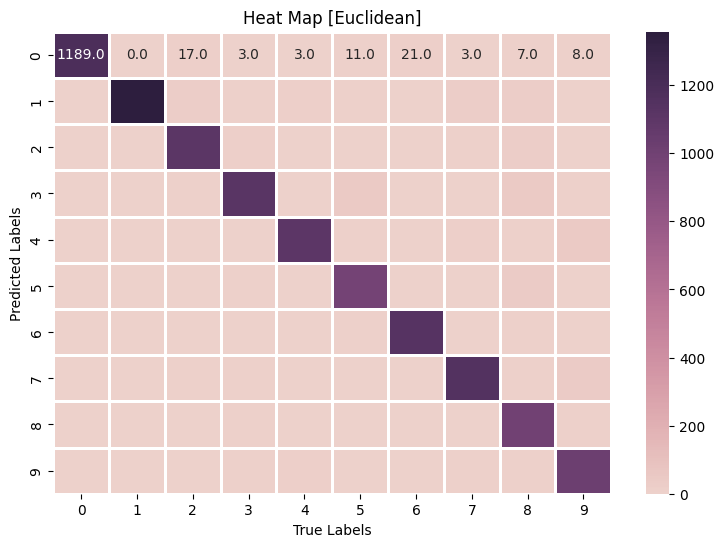

In [1270]:
# TODO: Perform cross-validation and then run your evaluation function for k=2, printing the accuracy and macro-average F1 score.

k = 2
num_of_folds = 5

print('K Fold Cross Validation for [k = 2] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_12, accuracy_12, macro_avg_f1_12 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_12)
print('Macro Average F1 [Manhattan]', macro_avg_f1_12)
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_12)
make_heat_map(confusion_matrix_12,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 2] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_22, accuracy_22, macro_avg_f1_22 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_22)
print('Macro Average F1 [Euclidean]', macro_avg_f1_22)
print('Confusion Matrix [Euclidean]') 
print(confusion_matrix_22)
make_heat_map(confusion_matrix_22,'Heat Map [Euclidean]')

K Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]
Accuracy [Manhattan]: 0.9421848739495798
Macro Average F1 [Manhattan] 0.9418766558930702
Confusion Matrix [Manhattan]
[[1.185e+03 0.000e+00 1.100e+01 0.000e+00 1.000e+00 1.000e+01 1.600e+01
  3.000e+00 1.200e+01 9.000e+00]
 [1.000e+00 1.352e+03 3.100e+01 1.200e+01 1.800e+01 1.000e+01 5.000e+00
  2.800e+01 4.000e+01 7.000e+00]
 [2.000e+00 4.000e+00 1.097e+03 1.200e+01 0.000e+00 1.000e+00 1.000e+00
  6.000e+00 1.500e+01 2.000e+00]
 [2.000e+00 1.000e+00 8.000e+00 1.112e+03 0.000e+00 2.700e+01 0.000e+00
  0.000e+00 3.800e+01 8.000e+00]
 [0.000e+00 2.000e+00 4.000e+00 0.000e+00 1.080e+03 3.000e+00 0.000e+00
  5.000e+00 9.000e+00 2.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 1.400e+01 0.000e+00 1.002e+03 6.000e+00
  0.000e+00 2.800e+01 3.000e+00]
 [1.000e+00 1.000e+00 4.000e+00 1.000e+00 8.000e+00 1.400e+01 1.144e+03
  0.000e+00 6.000e+00 1.000e+00]
 [1.000e+00 3.000e+00 2.400e+01 1.100e+01 4.000e+00 3.000e+00 0.000e+00
  1.

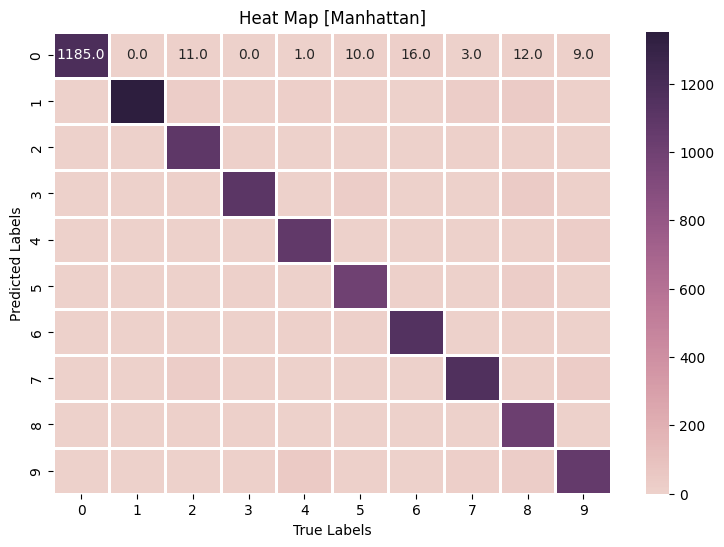

K Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9504201680672268
Macro Average F1 [Euclidean] 0.9501006429654384
Confusion Matrix [Euclidean]
[[1.187e+03 0.000e+00 9.000e+00 1.000e+00 2.000e+00 1.300e+01 1.200e+01
  3.000e+00 6.000e+00 7.000e+00]
 [1.000e+00 1.351e+03 1.700e+01 1.000e+01 1.400e+01 9.000e+00 5.000e+00
  2.500e+01 2.600e+01 6.000e+00]
 [1.000e+00 5.000e+00 1.118e+03 1.200e+01 1.000e+00 1.000e+00 1.000e+00
  7.000e+00 1.500e+01 1.000e+00]
 [1.000e+00 1.000e+00 7.000e+00 1.117e+03 0.000e+00 3.200e+01 0.000e+00
  0.000e+00 2.900e+01 8.000e+00]
 [0.000e+00 2.000e+00 6.000e+00 0.000e+00 1.085e+03 3.000e+00 0.000e+00
  6.000e+00 6.000e+00 1.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 1.300e+01 0.000e+00 1.000e+03 4.000e+00
  0.000e+00 2.300e+01 3.000e+00]
 [1.000e+00 1.000e+00 4.000e+00 1.000e+00 6.000e+00 1.200e+01 1.149e+03
  0.000e+00 4.000e+00 2.000e+00]
 [1.000e+00 3.000e+00 1.700e+01 1.000e+01 2.000e+00 1.000e+00 0.000e+00
  1.156e+03 4

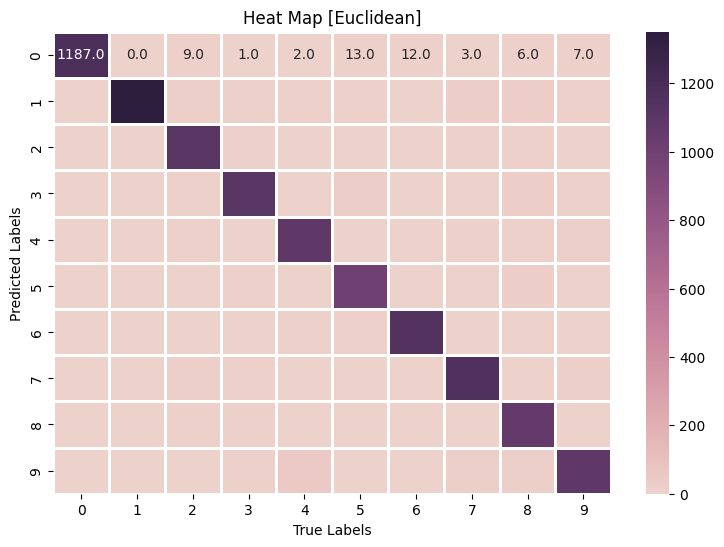

In [1271]:
# TODO: Perform cross-validation and then run your evaluation function for k=3, printing the accuracy and macro-average F1 score.

k = 3
num_of_folds = 5

print('K Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_13, accuracy_13, macro_avg_f1_13 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_13)
print('Macro Average F1 [Manhattan]', macro_avg_f1_13)
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_13)
make_heat_map(confusion_matrix_13,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_23, accuracy_23, macro_avg_f1_23 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_23)
print('Macro Average F1 [Euclidean]', macro_avg_f1_23)
print('Confusion Matrix [Euclidean]') 
print(confusion_matrix_23)
make_heat_map(confusion_matrix_23,'Heat Map [Euclidean]')

K Fold Cross Validation for [k = 4] - [Manhattan Distance] - [5 folds]
Accuracy [Manhattan]: 0.9403361344537815
Macro Average F1 [Manhattan] 0.9399705878107257
Confusion Matrix [Manhattan]
[[1.188e+03 0.000e+00 1.200e+01 0.000e+00 1.000e+00 7.000e+00 1.700e+01
  2.000e+00 1.000e+01 9.000e+00]
 [1.000e+00 1.352e+03 3.500e+01 1.500e+01 2.000e+01 1.600e+01 7.000e+00
  2.700e+01 4.700e+01 6.000e+00]
 [1.000e+00 4.000e+00 1.097e+03 1.500e+01 0.000e+00 2.000e+00 0.000e+00
  4.000e+00 1.300e+01 2.000e+00]
 [0.000e+00 2.000e+00 7.000e+00 1.112e+03 0.000e+00 4.000e+01 0.000e+00
  0.000e+00 3.900e+01 8.000e+00]
 [1.000e+00 1.000e+00 3.000e+00 0.000e+00 1.095e+03 1.000e+00 0.000e+00
  4.000e+00 1.200e+01 2.400e+01]
 [1.000e+00 0.000e+00 2.000e+00 1.200e+01 0.000e+00 9.840e+02 8.000e+00
  0.000e+00 3.500e+01 3.000e+00]
 [1.000e+00 1.000e+00 2.000e+00 1.000e+00 7.000e+00 1.400e+01 1.140e+03
  0.000e+00 8.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.000e+01 1.100e+01 8.000e+00 4.000e+00 1.000e+00
  1.

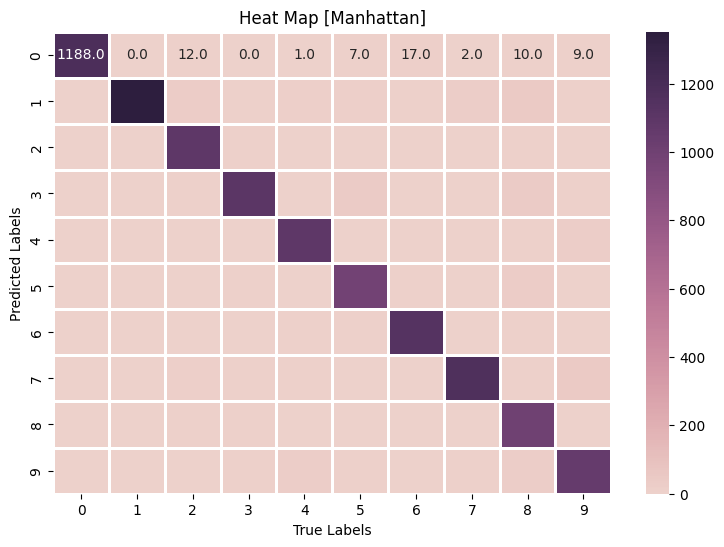

K Fold Cross Validation for [k = 4] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9485714285714286
Macro Average F1 [Euclidean] 0.948213179105912
Confusion Matrix [Euclidean]
[[1.188e+03 0.000e+00 1.200e+01 0.000e+00 1.000e+00 8.000e+00 1.400e+01
  2.000e+00 7.000e+00 1.000e+01]
 [1.000e+00 1.352e+03 2.500e+01 1.100e+01 1.500e+01 1.200e+01 5.000e+00
  2.400e+01 2.900e+01 6.000e+00]
 [1.000e+00 5.000e+00 1.110e+03 1.300e+01 0.000e+00 1.000e+00 0.000e+00
  6.000e+00 8.000e+00 1.000e+00]
 [0.000e+00 1.000e+00 4.000e+00 1.121e+03 0.000e+00 3.500e+01 0.000e+00
  0.000e+00 3.600e+01 8.000e+00]
 [1.000e+00 1.000e+00 6.000e+00 0.000e+00 1.100e+03 1.000e+00 0.000e+00
  5.000e+00 9.000e+00 2.100e+01]
 [1.000e+00 1.000e+00 1.000e+00 8.000e+00 0.000e+00 9.930e+02 7.000e+00
  0.000e+00 2.800e+01 3.000e+00]
 [1.000e+00 0.000e+00 1.000e+00 1.000e+00 6.000e+00 1.300e+01 1.146e+03
  0.000e+00 8.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.000e+01 1.000e+01 3.000e+00 3.000e+00 0.000e+00
  1.165e+03 7.

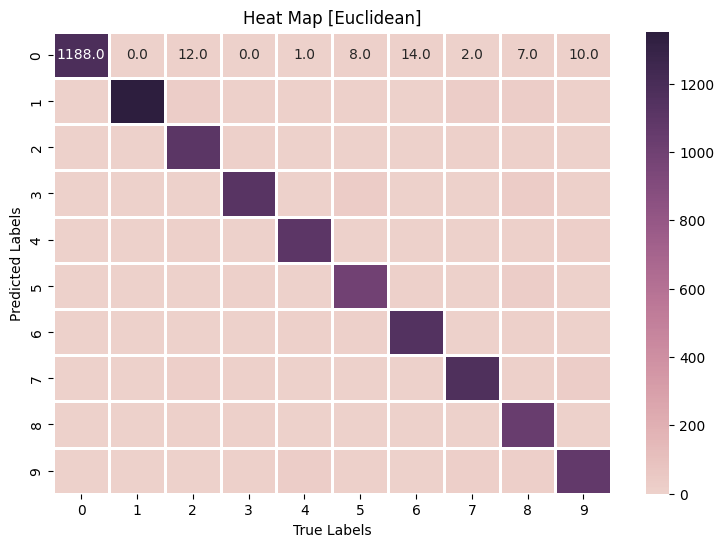

In [1272]:
# TODO: Perform cross-validation and then run your evaluation function for k=4, printing the accuracy and macro-average F1 score.

k = 4
num_of_folds = 5

print('K Fold Cross Validation for [k = 4] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_14, accuracy_14, macro_avg_f1_14 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_14)
print('Macro Average F1 [Manhattan]', macro_avg_f1_14)
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_14)
make_heat_map(confusion_matrix_14,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 4] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_24, accuracy_24, macro_avg_f1_24 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_24)
print('Macro Average F1 [Euclidean]', macro_avg_f1_24)
print('Confusion Matrix [Euclidean]') 
print(confusion_matrix_24)
make_heat_map(confusion_matrix_24,'Heat Map [Euclidean]')

K Fold Cross Validation for [k = 5] - [Manhattan Distance] - [5 folds]
Accuracy [Manhattan]: 0.9405882352941176
Macro Average F1 [Manhattan] 0.940310939982208
Confusion Matrix [Manhattan] [[1.187e+03 0.000e+00 9.000e+00 0.000e+00 2.000e+00 8.000e+00 9.000e+00
  2.000e+00 1.100e+01 7.000e+00]
 [1.000e+00 1.352e+03 3.400e+01 1.600e+01 2.000e+01 1.900e+01 6.000e+00
  2.600e+01 4.700e+01 8.000e+00]
 [2.000e+00 4.000e+00 1.089e+03 1.300e+01 1.000e+00 0.000e+00 2.000e+00
  3.000e+00 9.000e+00 2.000e+00]
 [0.000e+00 1.000e+00 8.000e+00 1.101e+03 0.000e+00 3.700e+01 0.000e+00
  1.000e+00 3.700e+01 7.000e+00]
 [0.000e+00 1.000e+00 6.000e+00 0.000e+00 1.074e+03 1.000e+00 0.000e+00
  5.000e+00 8.000e+00 1.400e+01]
 [1.000e+00 0.000e+00 2.000e+00 2.300e+01 0.000e+00 9.870e+02 5.000e+00
  0.000e+00 3.000e+01 5.000e+00]
 [2.000e+00 1.000e+00 2.000e+00 1.000e+00 6.000e+00 1.400e+01 1.149e+03
  0.000e+00 9.000e+00 0.000e+00]
 [1.000e+00 4.000e+00 2.600e+01 1.000e+01 7.000e+00 3.000e+00 1.000e+00
  1.1

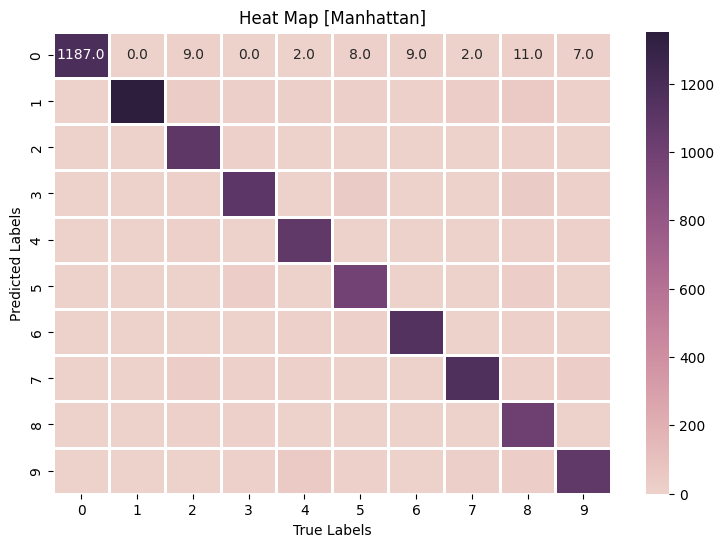

K Fold Cross Validation for [k = 5] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9472268907563025
Macro Average F1 [Euclidean] 0.9468785313639027
Confusion Matrix [Euclidean] [[1.188e+03 0.000e+00 1.000e+01 0.000e+00 3.000e+00 9.000e+00 1.100e+01
  3.000e+00 6.000e+00 8.000e+00]
 [1.000e+00 1.352e+03 2.400e+01 1.100e+01 1.600e+01 1.200e+01 5.000e+00
  2.400e+01 2.600e+01 7.000e+00]
 [2.000e+00 5.000e+00 1.105e+03 1.100e+01 1.000e+00 1.000e+00 1.000e+00
  4.000e+00 9.000e+00 1.000e+00]
 [0.000e+00 1.000e+00 7.000e+00 1.116e+03 0.000e+00 3.000e+01 0.000e+00
  1.000e+00 3.500e+01 8.000e+00]
 [0.000e+00 1.000e+00 6.000e+00 0.000e+00 1.074e+03 2.000e+00 0.000e+00
  6.000e+00 9.000e+00 1.400e+01]
 [1.000e+00 1.000e+00 0.000e+00 1.600e+01 0.000e+00 9.990e+02 5.000e+00
  0.000e+00 2.700e+01 4.000e+00]
 [1.000e+00 0.000e+00 4.000e+00 2.000e+00 5.000e+00 1.500e+01 1.149e+03
  0.000e+00 7.000e+00 0.000e+00]
 [1.000e+00 3.000e+00 2.200e+01 1.000e+01 6.000e+00 2.000e+00 0.000e+00
  1.158e+03 8

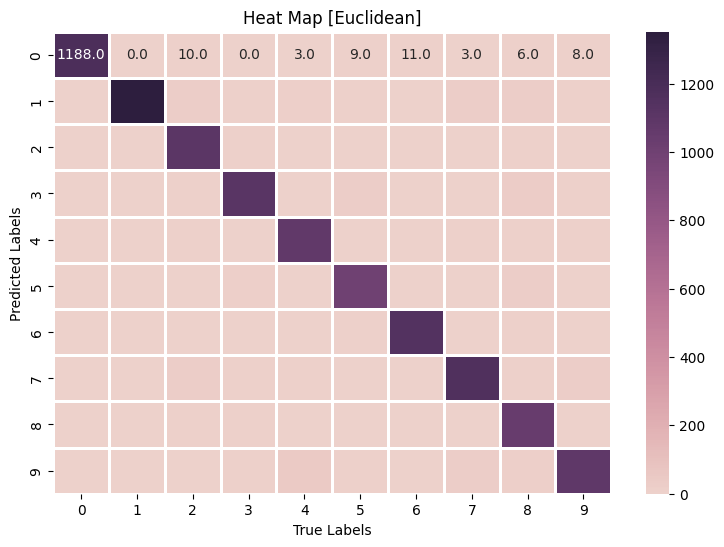

In [1273]:
# TODO: Perform cross-validation and then run your evaluation function for k=5, printing the accuracy and macro-average F1 score.

k = 5
num_of_folds = 5

print('K Fold Cross Validation for [k = 5] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, manhattan_distance)
confusion_matrix_15, accuracy_15, macro_avg_f1_15 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_15)
print('Macro Average F1 [Manhattan]', macro_avg_f1_15)
print('Confusion Matrix [Manhattan]', confusion_matrix_15)
make_heat_map(confusion_matrix_15,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 5] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, k, data_train, euclidean_distance)
confusion_matrix_25, accuracy_25, macro_avg_f1_25 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_25)
print('Macro Average F1 [Euclidean]', macro_avg_f1_25)
print('Confusion Matrix [Euclidean]', confusion_matrix_25)
make_heat_map(confusion_matrix_25,'Heat Map [Euclidean]')

Next, present the results as a graph with `k` values on the x-axis and classification accuracy on the y-axis. 

Use a single plot to compare the two versions of the classifier (one using Euclidean and the other using Manhattan distance metric). Make another graph but with the F1-score on the y-axis this time. The graphs should be properly labeled.

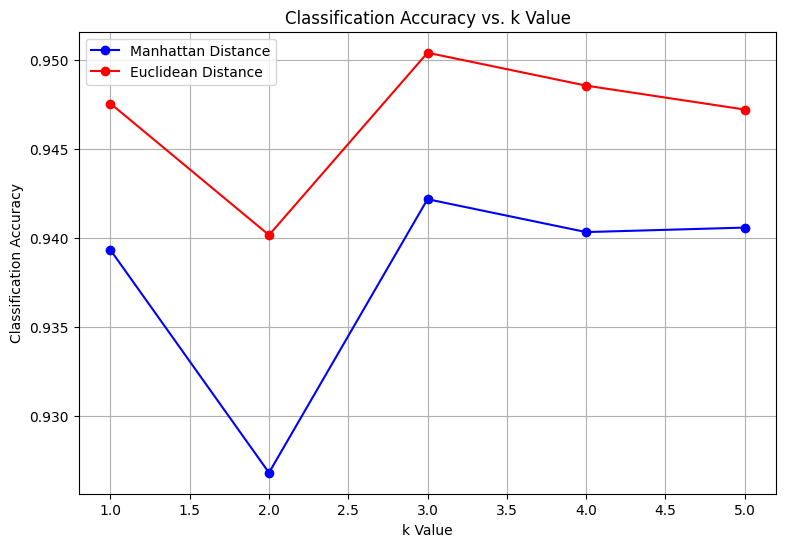

In [1275]:
## (3 marks)
# TODO: Plot a graph with k values on the x-axis and classification accuracy on the y-axis

values_of_k = [1, 2, 3, 4, 5]
accuracies_manhattan = [accuracy_1, accuracy_12, accuracy_13, accuracy_14, accuracy_15]  # Accuracies for 'manhattan' distance function
accuracies_euclidean = [accuracy_2, accuracy_22, accuracy_23, accuracy_24, accuracy_25]  # Accuracies for 'euclidean' distance function

plt.figure(figsize = (9, 6))

plt.plot(values_of_k, accuracies_manhattan, marker = 'o', linestyle = '-', color = 'b', label = 'Manhattan Distance')
plt.plot(values_of_k, accuracies_euclidean, marker = 'o', linestyle = '-', color = 'r', label = 'Euclidean Distance')

plt.title('Classification Accuracy vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Classification Accuracy')
plt.grid(True)
plt.legend() 
plt.show()

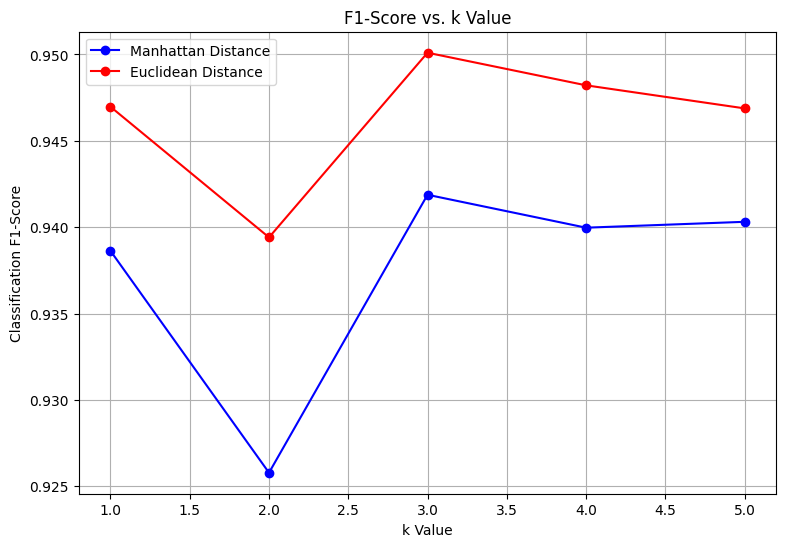

In [1276]:
## (3 marks)
# TODO: Plot a graph with k values on the x-axis and F1-score on the y-axis

values_of_k = [1, 2, 3, 4, 5]
f1_scores_manhattan = [macro_avg_f1_1, macro_avg_f1_12, macro_avg_f1_13, macro_avg_f1_14, macro_avg_f1_15]
f1_scores_euclidean = [macro_avg_f1_2, macro_avg_f1_22, macro_avg_f1_23, macro_avg_f1_24, macro_avg_f1_25]

plt.figure(figsize = (9, 6))

plt.plot(values_of_k, f1_scores_manhattan, marker = 'o', linestyle = '-', color = 'b', label = 'Manhattan Distance')
plt.plot(values_of_k, f1_scores_euclidean, marker = 'o', linestyle = '-', color = 'r', label = 'Euclidean Distance')

plt.title('F1-Score vs. k Value')
plt.xlabel('k Value')
plt.ylabel('Classification F1-Score')
plt.grid(True)
plt.legend()
plt.show()

Comment on the best value of k you have found for both distance metrics using
cross-validation. What impact does this value have on the decision boundries generated by the model and the stability of decisions?

In [1287]:
## (2 marks)
# TODO: Write your answer below as a comment
# Now from the cross validation results obtained for values of k ranging from 1 to 5, we can make a series of comments.
# Smaller values of k (such as k = 1 or 2) seem to create decision boundaries that are highly influenced by individual data points. This can result in decision boundaries that are more complex and sensitive to noise in the data. Hence, such models are more prone to overfitting, meaning they may not generalize well to new, unseen data.
# On the other hand, larger values of k (such as k = 4 or 5) create decision boundaries that are relatively smoother and less sensitive to individual data points. But this maye result is an underfitted model.
# Hence, we can choose the value of k = 3, as it is a sort of balance between the two extremes mentioned earlier. Plus, it also has the highest accuracy as observed from the graphs obtained. 

Finally, use the best value of `k` for both distance metrics and run it on the test dataset.

Find the confusion matrix, classification accuracy and F1 score and print them.

The confusion matrix must be displayed as a heatmap annotated with the data values. The axes should be properly labelled and the colormap used needs to be shown next to the heatmap.

K Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]
Accuracy [Manhattan]: 0.9421848739495798
Macro Average F1 [Manhattan] 0.9418766558930702
Confusion Matrix [Manhattan]
[[1.185e+03 0.000e+00 1.100e+01 0.000e+00 1.000e+00 1.000e+01 1.600e+01
  3.000e+00 1.200e+01 9.000e+00]
 [1.000e+00 1.352e+03 3.100e+01 1.200e+01 1.800e+01 1.000e+01 5.000e+00
  2.800e+01 4.000e+01 7.000e+00]
 [2.000e+00 4.000e+00 1.097e+03 1.200e+01 0.000e+00 1.000e+00 1.000e+00
  6.000e+00 1.500e+01 2.000e+00]
 [2.000e+00 1.000e+00 8.000e+00 1.112e+03 0.000e+00 2.700e+01 0.000e+00
  0.000e+00 3.800e+01 8.000e+00]
 [0.000e+00 2.000e+00 4.000e+00 0.000e+00 1.080e+03 3.000e+00 0.000e+00
  5.000e+00 9.000e+00 2.300e+01]
 [2.000e+00 0.000e+00 0.000e+00 1.400e+01 0.000e+00 1.002e+03 6.000e+00
  0.000e+00 2.800e+01 3.000e+00]
 [1.000e+00 1.000e+00 4.000e+00 1.000e+00 8.000e+00 1.400e+01 1.144e+03
  0.000e+00 6.000e+00 1.000e+00]
 [1.000e+00 3.000e+00 2.400e+01 1.100e+01 4.000e+00 3.000e+00 0.000e+00
  1.

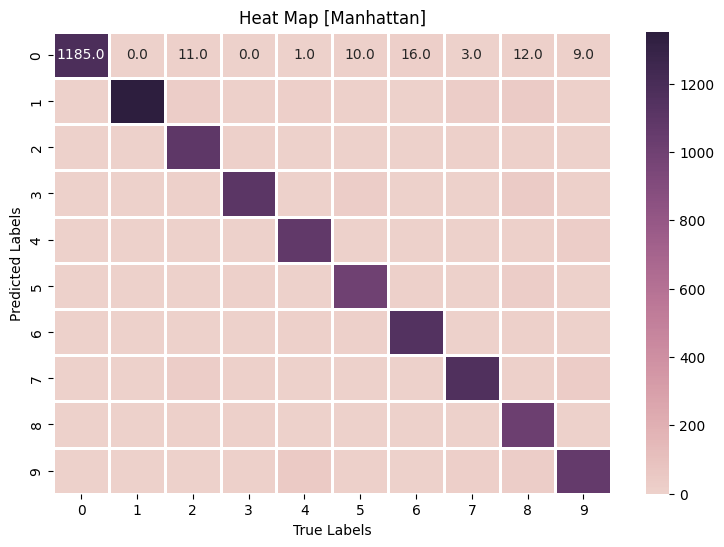

K Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]
Accuracy [Euclidean]: 0.9504201680672268
Macro Average F1 [Euclidean] 0.9501006429654384
Confusion Matrix [Euclidean]
[[1.187e+03 0.000e+00 9.000e+00 1.000e+00 2.000e+00 1.300e+01 1.200e+01
  3.000e+00 6.000e+00 7.000e+00]
 [1.000e+00 1.351e+03 1.700e+01 1.000e+01 1.400e+01 9.000e+00 5.000e+00
  2.500e+01 2.600e+01 6.000e+00]
 [1.000e+00 5.000e+00 1.118e+03 1.200e+01 1.000e+00 1.000e+00 1.000e+00
  7.000e+00 1.500e+01 1.000e+00]
 [1.000e+00 1.000e+00 7.000e+00 1.117e+03 0.000e+00 3.200e+01 0.000e+00
  0.000e+00 2.900e+01 8.000e+00]
 [0.000e+00 2.000e+00 6.000e+00 0.000e+00 1.085e+03 3.000e+00 0.000e+00
  6.000e+00 6.000e+00 1.700e+01]
 [1.000e+00 0.000e+00 0.000e+00 1.300e+01 0.000e+00 1.000e+03 4.000e+00
  0.000e+00 2.300e+01 3.000e+00]
 [1.000e+00 1.000e+00 4.000e+00 1.000e+00 6.000e+00 1.200e+01 1.149e+03
  0.000e+00 4.000e+00 2.000e+00]
 [1.000e+00 3.000e+00 1.700e+01 1.000e+01 2.000e+00 1.000e+00 0.000e+00
  1.156e+03 4

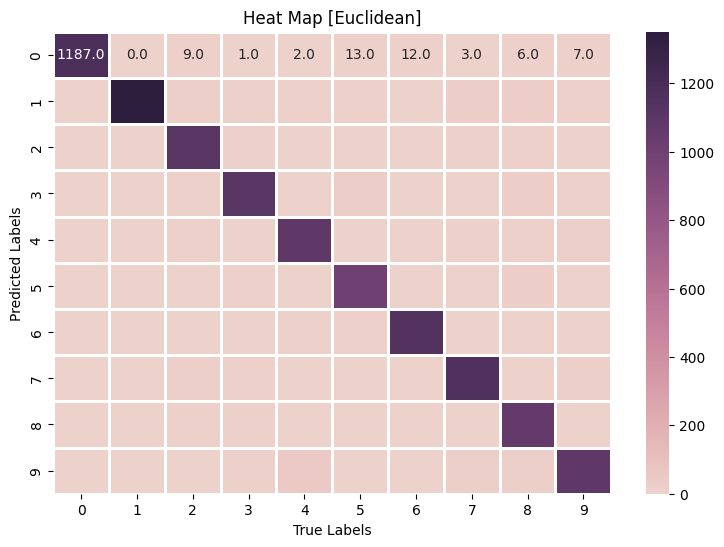

In [1286]:
## (3 marks)
# TODO: Use the best value of k on test dataset (for both distance metrics).

best_val_of_k = 3
num_of_folds = 5

print('K Fold Cross Validation for [k = 3] - [Manhattan Distance] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, best_val_of_k, data_train, manhattan_distance)
confusion_matrix_13, accuracy_13, macro_avg_f1_13 = evaluation(predicted_labels, labels_train)
print('Accuracy [Manhattan]:', accuracy_13)
print('Macro Average F1 [Manhattan]', macro_avg_f1_13)
print('Confusion Matrix [Manhattan]') 
print(confusion_matrix_13)
make_heat_map(confusion_matrix_13,'Heat Map [Manhattan]')

print('K Fold Cross Validation for [k = 3] - [Euclidean] - [5 folds]')
predicted_labels = k_fold_cross_validation(num_of_folds, best_val_of_k, data_train, euclidean_distance)
confusion_matrix_23, accuracy_23, macro_avg_f1_23 = evaluation(predicted_labels, labels_train)
print('Accuracy [Euclidean]:', accuracy_23)
print('Macro Average F1 [Euclidean]', macro_avg_f1_23)
print('Confusion Matrix [Euclidean]') 
print(confusion_matrix_23)
make_heat_map(confusion_matrix_23,'Heat Map [Euclidean]')


# A quick note for the person checking my part 1 of the assignment. I tried to print the values on my heatmap but for some odd reason, only the first row was printed while the rest of the heatmap was not annotated. Thats why you see all my heatmaps with only first row annotated. 

## **Part 2: Implement using Scikit-Learn (25 marks)**

In this part, you have to use [scikit-learn's k-NN implementation](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to train and test your classifier on the dataset used in Part 1. Repeat the tasks you have done in Part 1 but this time using scikit-learn. 

- Perform 5-fold cross-validation and run the k-NN classifier for values of `k = [1, 2, 3, 4, 5]` using both Euclidean and Manhattan distance.

- Use scikit-learn's [accuracy_score](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html) function to calculate the accuracy, the [classification_report](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.classification_report.html) to calculate macro-average F1 score,
and the [confusion_matrix](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html) function to calculate confusion matrix from the predicted labels. 

- Present the results as a graph with k values on the x-axis and performance measures on the y-axis just like you did in Part 1. Use a single plot to compare the two versions of the classifier (one using Euclidean and the other using Manhattan distance metric). 



In [1282]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# added libraries
from sklearn.model_selection import cross_val_predict

In [1283]:
# (10 marks)
# TODO:  Perform 5-fold cross-validation. 

# no need to reload the dataset sinch it is already loaded above
values_of_k = [1, 2, 3, 4, 5]
num_of_folds = 5

print('Distance Metrix = Euclidean Distance')
accuracy_euc = []
macroF1_euc = []
for k in values_of_k:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
    predicted_labels = cross_val_predict(estimator = knn, X = features_train, y = labels_train, cv = num_of_folds)
    accuracy_euc.append(accuracy_score(labels_train, predicted_labels))
    macroF1_euc.append(classification_report(labels_train, predicted_labels, output_dict = True)['macro avg']['f1-score'])
    confusion = confusion_matrix(labels_train, predicted_labels)
    print("Euclidean Distance Accuracy for k =", k) 
    print("Accuracy: ", accuracy_euc[k - 1]) 
    print("MacroF1: ", macroF1_euc[k - 1])

print("\n")
print('Distance Metrix = Manhatten Distance')
accuracy_manh = []
macroF1_manh = []
for k in values_of_k:
    knn = KNeighborsClassifier(n_neighbors = k, metric = 'manhattan')
    predicted_labels = cross_val_predict(estimator = knn, X = features_train, y = labels_train, cv = num_of_folds)
    accuracy_manh.append(accuracy_score(labels_train, predicted_labels))
    macroF1_manh.append(classification_report(labels_train, predicted_labels, output_dict = True)['macro avg']['f1-score'])
    confusion = confusion_matrix(labels_train, predicted_labels)
    print("Manhattan Distance Accuracy for k =", k) 
    print("Accuracy: ", accuracy_euc[k - 1])
    print("MacroF1: ", macroF1_euc[k - 1])

Distance Metrix = Euclidean Distance
Euclidean Distance Accuracy for k = 1
Accuracy:  0.9478991596638655
MacroF1:  0.9473333753087972
Euclidean Distance Accuracy for k = 2
Accuracy:  0.94
MacroF1:  0.939244226789496
Euclidean Distance Accuracy for k = 3
Accuracy:  0.9506722689075631
MacroF1:  0.9503868912786138
Euclidean Distance Accuracy for k = 4
Accuracy:  0.9484033613445378
MacroF1:  0.948040251424606
Euclidean Distance Accuracy for k = 5
Accuracy:  0.9477310924369748
MacroF1:  0.9473876821707105


Distance Metrix = Manhatten Distance
Manhattan Distance Accuracy for k = 1
Accuracy:  0.9478991596638655
MacroF1:  0.9473333753087972
Manhattan Distance Accuracy for k = 2
Accuracy:  0.94
MacroF1:  0.939244226789496
Manhattan Distance Accuracy for k = 3
Accuracy:  0.9506722689075631
MacroF1:  0.9503868912786138
Manhattan Distance Accuracy for k = 4
Accuracy:  0.9484033613445378
MacroF1:  0.948040251424606
Manhattan Distance Accuracy for k = 5
Accuracy:  0.9477310924369748
MacroF1:  0.947

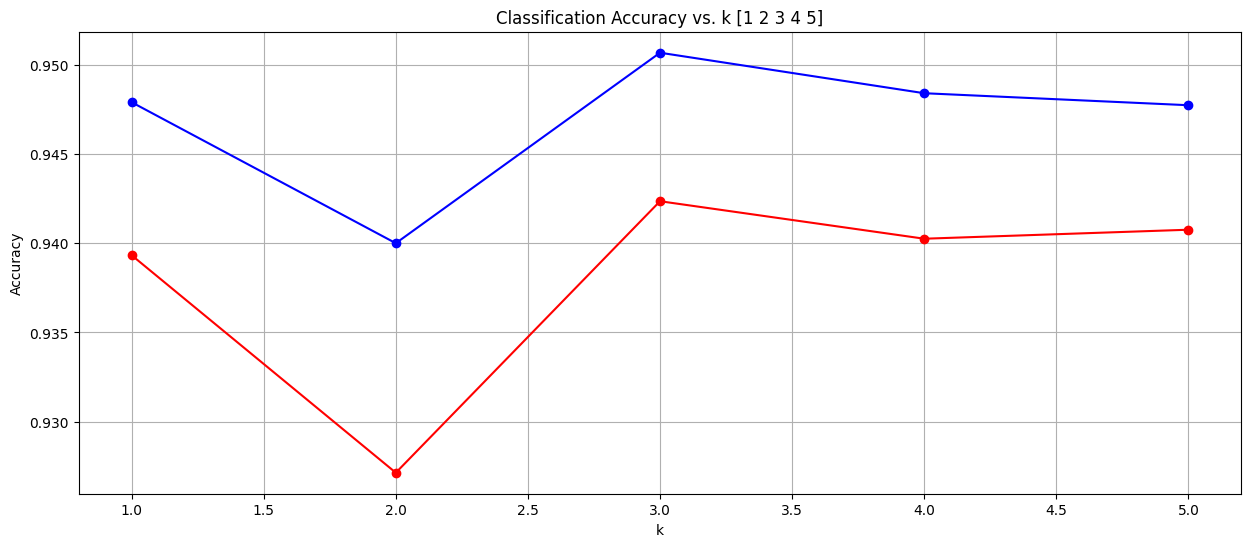

In [1284]:
# (5 marks)
# TODO: Plot a graph with k values on the x-axis and classifcation accuracy on the y-axis

k_values = [1, 2, 3, 4, 5]

plt.figure(figsize = (15, 6))
plt.plot(k_values, accuracy_euc, marker='o', linestyle = '-', color = 'b')
plt.plot(k_values, accuracy_manh, marker='o', linestyle = '-', color = 'r')
plt.title('Classification Accuracy vs. k [1 2 3 4 5]')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.grid(True)


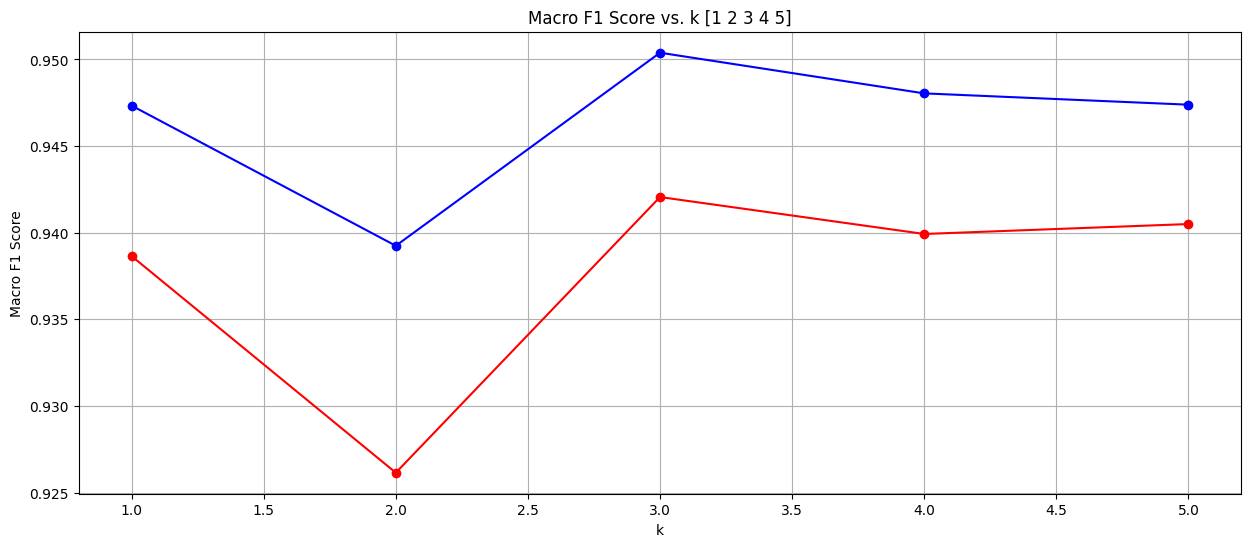

In [1285]:
## (5 marks)
# TODO: Plot a graph with k values on the x-axis and F1-score on the y-axis

k_values = [1, 2, 3, 4, 5]

plt.figure(figsize = (15, 6))
plt.plot(k_values, macroF1_euc, marker = 'o', linestyle = '-', color = 'b')
plt.plot(k_values, macroF1_manh, marker = 'o', linestyle = '-', color = 'r')
plt.title('Macro F1 Score vs. k [1 2 3 4 5]')
plt.xlabel('k')
plt.ylabel('Macro F1 Score')
plt.grid(True)

Finally, print the best values of k for both distance metrics. Then use these values of k on the test dataset and print the evaluation scores and confusion matrix (as a heatmap) for each of the distance metrics.


Best value of k for Manhattan Distance: 3
Best value of k for Euclidean Distance: 3
Distance Metric = Euclidean Distance
Euclidean Distance Accuracy and MacroF1 for k = 3
Accuracy:  0.9576190476190476
MacroF1:  0.9572796697566156


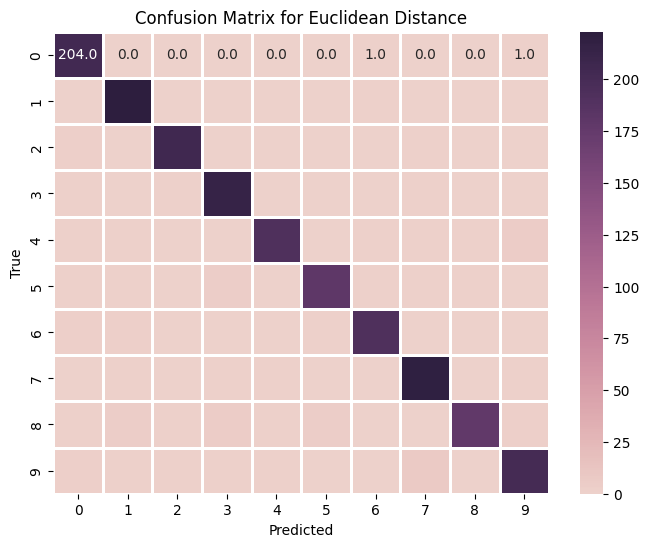



Distance Metric = Manhattan Distance
Manhattan Distance Accuracy and MacroF1 for k = 3
Accuracy:  0.9471428571428572
MacroF1:  0.9467186167679322


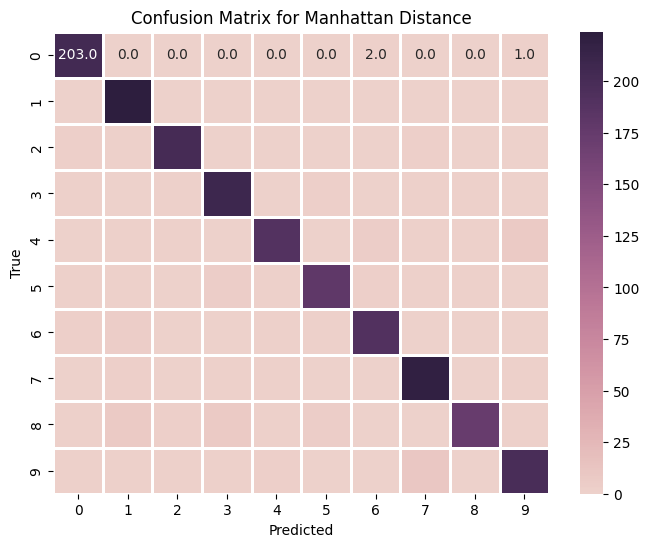

In [1281]:
# TODO: Use the best value of k on the test dataset (for both distance metrics).

print("Best value of k for Manhattan Distance: 3")
print("Best value of k for Euclidean Distance: 3")

best_value_of_k = 3
num_of_folds = 5

print('Distance Metric = Euclidean Distance')
knn_euc = KNeighborsClassifier(n_neighbors = best_value_of_k, metric = 'euclidean')
knn_euc.fit(features_train, labels_train)
predicted_labels_euc = knn_euc.predict(features_test)
accuracy_euc = accuracy_score(labels_test, predicted_labels_euc)
macroF1_euc = classification_report(labels_test, predicted_labels_euc, output_dict = True)['macro avg']['f1-score']
confusion_euc = confusion_matrix(labels_test, predicted_labels_euc)
print("Euclidean Distance Accuracy and MacroF1 for k =", best_value_of_k)
print("Accuracy: ", accuracy_euc)
print("MacroF1: ", macroF1_euc)

# printing the confusion matrix as a heatmap with a color bar for Euclidean Distance
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_euc, annot = True, cmap = sns.cubehelix_palette(as_cmap = True), linewidths = 1, fmt='.1f')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Euclidean Distance")
plt.show()

#############################################################################################

print("\n")
print('Distance Metric = Manhattan Distance')
knn_manh = KNeighborsClassifier(n_neighbors = best_value_of_k, metric = 'manhattan')
knn_manh.fit(features_train, labels_train)
predicted_labels_manh = knn_manh.predict(features_test)
accuracy_manh = accuracy_score(labels_test, predicted_labels_manh)
macroF1_manh = classification_report(labels_test, predicted_labels_manh, output_dict=True)['macro avg']['f1-score']
confusion_manh = confusion_matrix(labels_test, predicted_labels_manh)
print("Manhattan Distance Accuracy and MacroF1 for k =", best_value_of_k)
print("Accuracy: ", accuracy_manh)
print("MacroF1: ", macroF1_manh)

# printing the confusion matrix as a heatmap with a color bar for Manhattan Distance
plt.figure(figsize = (8, 6))
sns.heatmap(confusion_manh, annot = True, cmap = sns.cubehelix_palette(as_cmap = True), linewidths = 1, fmt='.1f')
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix for Manhattan Distance")
plt.show()

# Testing the classifier with your own handwriting!

Gradio is an open-source Python library that is used to build machine learning and data science demos and web applications. 

We can use the sketchpad interface to write our digits and pass that to our classifier. Try it out below! 

In [1247]:
import gradio as gr

In [1249]:
### Initialize your classifier here ####

### Try this with out with your own classifiers
k = 3
my_classifier = kNearestNeighbours(k)
my_classifier.fit(features_train, labels_train)
my_sk_classifer = KNeighborsClassifier(n_neighbors = k, metric = 'euclidean')
my_sk_classifer.fit(features_train,labels_train)

KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [1262]:
def sketch_recognition(img):
    image_arr = np.array([])
    image_arr = img.flatten()
    #label = my_classifier.predict([image_arr],euclidean_distance)
    label = my_sk_classifer.predict([image_arr])

    print("Your label: ",label[0])
    return str(label[0])


In [1263]:
iface = gr.Interface(fn=sketch_recognition, inputs="sketchpad", outputs="text")
iface.launch(debug=True)

Running on local URL:  http://127.0.0.1:7864

To create a public link, set `share=True` in `launch()`.


Keyboard interruption in main thread... closing server.


In [1268]:
## Draw and save your handwritten digits as an image (if you want)

gr.Interface(lambda x:x, "sketchpad", "image").launch()

Running on local URL:  http://127.0.0.1:7865

To create a public link, set `share=True` in `launch()`.


Your label:  1
Prediction for the image 1: 1


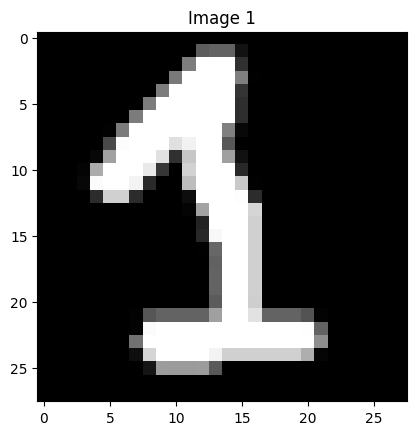

Your label:  2
Prediction for the image 2: 2


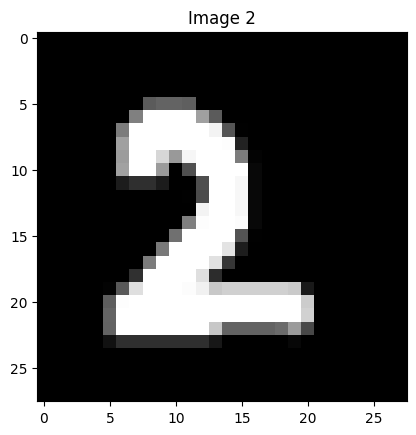

Your label:  3
Prediction for the image 3: 3


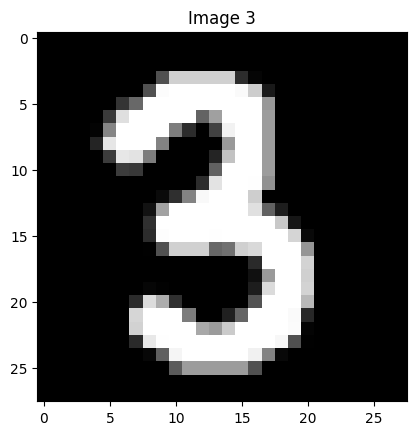

Your label:  4
Prediction for the image 4: 4


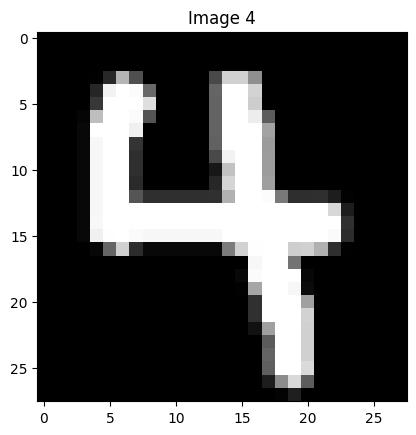

Your label:  5
Prediction for the image 5: 5


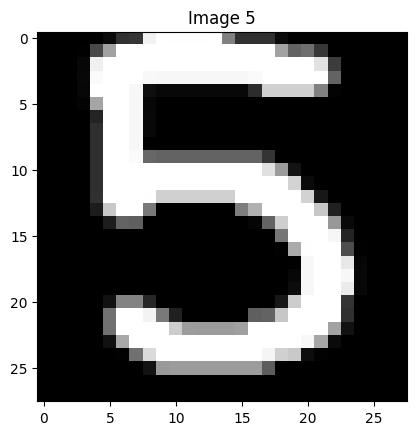

In [1269]:
## (5 marks)
## TODO: Use images of your own handwritten digits and make a prediction using your own classifier.
## You can use the sketchpad above if you'd like or even use pencil and paper to write out some numbers and then take a picture.
## Display five of these images and print out the corresponding prediction
## You can use either your own classifier or sklearn.

## Have fun!!


from PIL import Image

image1 = Image.open('C:\\Users\\sadaa\\Desktop\\1.png')
image2 = Image.open('C:\\Users\\sadaa\\Desktop\\2.png')
image3 = Image.open('C:\\Users\\sadaa\\Desktop\\3.png')
image4 = Image.open('C:\\Users\\sadaa\\Desktop\\4.png')
image5 = Image.open('C:\\Users\\sadaa\\Desktop\\5.png')

images = [image1, image2, image3, image4, image5]

for i, image in enumerate(images):
    image_arr = np.array(image)
    prediction = sketch_recognition(image_arr)
    print(f"Prediction for the image {i + 1}: {prediction}")


    plt.imshow(image_arr, cmap='gray')
    plt.title(f"Image {i + 1}")
    plt.show()


## Fin.